# Figures for the heart

## Raster plot

In [1]:
import numpy as np 
import scipy as sp
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN


import os, sys
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)

import networkx as nx

from scipy.sparse import diags, coo_matrix
from scipy import sparse
import jax.numpy as jnp
from diffrax import diffeqsolve, ODETerm, SaveAt
import diffrax
import jax
from jax import lax, vmap, jit
import jax.random as random
from jax.experimental import sparse


In [2]:

def generate_laplacian(N, M, conduction_block_threshold, sparse_matrix=False, seed=0):
    num_nodes = N * M
    adj_rows = []
    adj_cols = []
    adj_data = []

    # Generate random conduction blocks
    np.random.seed(seed)
    conduction_blocks = np.random.rand(N, M) < conduction_block_threshold

    # Function to map grid (i, j) to a single node index
    def node_index(i, j):
        return i * M + j

    # Define neighbors for the nine-point stencil with weights
    neighbors = [
        (-1, 0, .5),     # up
        (1, 0, .5),      # down
        (0, -1, .5),     # left
        (0, 1, .5),      # right
        (-1, -1, .25),   # top-left
        (-1, 1, .25),    # top-right
        (1, -1, .25),    # bottom-left
        (1, 1, .25)      # bottom-right
    ]
    
    # Build adjacency structure excluding conduction blocks
    indices = np.array([[i, j] for i in range(N) for j in range(M)])
    idx = node_index(indices[:, 0], indices[:, 1])

    for di, dj, weight in neighbors:
        ni = indices[:, 0] + di
        nj = indices[:, 1] + dj

    # Step 1: Filter for in-bounds neighbors
        in_bounds = (ni >= 0) & (ni < N) & (nj >= 0) & (nj < M)
    
    # Step 2: Find valid indices (in-bounds) to avoid shape mismatches
        valid_indices = np.where(in_bounds)[0]
        ni_valid = ni[valid_indices]
        nj_valid = nj[valid_indices]

    # Step 3: Apply conduction block exclusion on the filtered indices
        valid_conduction = ~conduction_blocks[ni_valid, nj_valid]
        valid_node = ~conduction_blocks[indices[valid_indices, 0], indices[valid_indices, 1]]
        valid = valid_conduction & valid_node

    # Step 4: Append data for fully valid connections
        adj_rows.extend(idx[valid_indices][valid])
        adj_cols.extend(node_index(ni_valid[valid], nj_valid[valid]))
        adj_data.extend([weight] * int(np.sum(valid)))


    # Create adjacency and degree matrices
    adj_matrix = coo_matrix((adj_data, (adj_rows, adj_cols)), shape=(num_nodes, num_nodes))
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)

    # Construct Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix


    if sparse_matrix:

        return sparse.BCSR.from_scipy_sparse(laplacian_matrix), jnp.array(conduction_blocks)
    
    else:
        return laplacian_matrix.todense(), conduction_blocks



In [4]:
N_y=50
N_x=50
N=N_x*N_y
dts=500
L1, c1 = generate_laplacian(N_x,N_y,0, seed=1000, sparse_matrix=True)
L2,c2=generate_laplacian(N_x,N_y,0.5, seed=1000, sparse_matrix=True)

In [5]:

def FHN_graph(t, y, args):
    N, a, b, e, Du,L, c_blocks= args 
    u = y[:N]
    v = y[N:]
    
    du = a*u*(u-b)*(1-u) - Du*(L@u) - v 
    dv = e*(u-v)

    return jnp.append(du,dv)
#switched from Dopri5 to Dopri8 cause the former was getting stuck

def solve_heart(y0='wave',N=200*200, a=3, b=0.2, e=1e-2, Du=0.2, T=300, L=L1,c1=c1, max_steps=1000000,dts=6000,
                solver=diffrax.Dopri8(), rtol=1e-6, atol=1e-7, dt0=1e-2):
    indices = jnp.where((jnp.arange(N) % 50 == 0) & (c1.flatten() == 0))[0]
    if y0 == 'wave':
        y0 = jnp.zeros(2 * N, dtype=jnp.float32)
        y0 = y0.at[indices].set(0.1)
    term = ODETerm(FHN_graph)
    saveat = SaveAt(ts=jnp.linspace(0, T, dts))  # Reduced save points
    stepsize_controller = diffrax.PIDController(rtol=rtol, atol=atol)

    # Switch to a less memory-intensive solver, e.g., Tsit5 or BDF
    sol = diffeqsolve(term, solver, 0, T, dt0, y0, args=(N, a, b, e, Du, L, c1),
                      saveat=saveat, max_steps=max_steps, stepsize_controller=stepsize_controller)

    return sol


In [6]:
def threshold_matrix(matrix: jnp.ndarray, threshold: float) -> jnp.ndarray:
    """
    Scans a JAX matrix and returns a binary matrix where elements above 
    the threshold are 1 and elements below or equal to the threshold are 0.
    
    Parameters:
    matrix (jnp.ndarray): Input JAX matrix.
    threshold (float): Threshold value.
    
    Returns:
    jnp.ndarray: A binary matrix of the same shape as the input.
    """
    # Use jax.numpy.where to create a binary matrix
    return jnp.where(matrix > threshold, 1, 0)


In [10]:

dts=1400
sol1 = solve_heart(N=N,T=500,L=L1, c1=c1,a=3,b=0.05,Du=0.04, dts=dts)
sol2 = solve_heart(N=N,T=500,L=L2, c1=c2, a=3,b=0.05,Du=0.04, dts=dts)
u_sol1 = sol1.ys[:,:N].T 
binary1=threshold_matrix(u_sol1,0.08)
binary1=binary1.reshape(N_x,N_y,-1)
u_sol2 = sol2.ys[:,:N].T 
binary2=threshold_matrix(u_sol2,0.08)
binary2=binary2.reshape(N_x,N_y,-1)

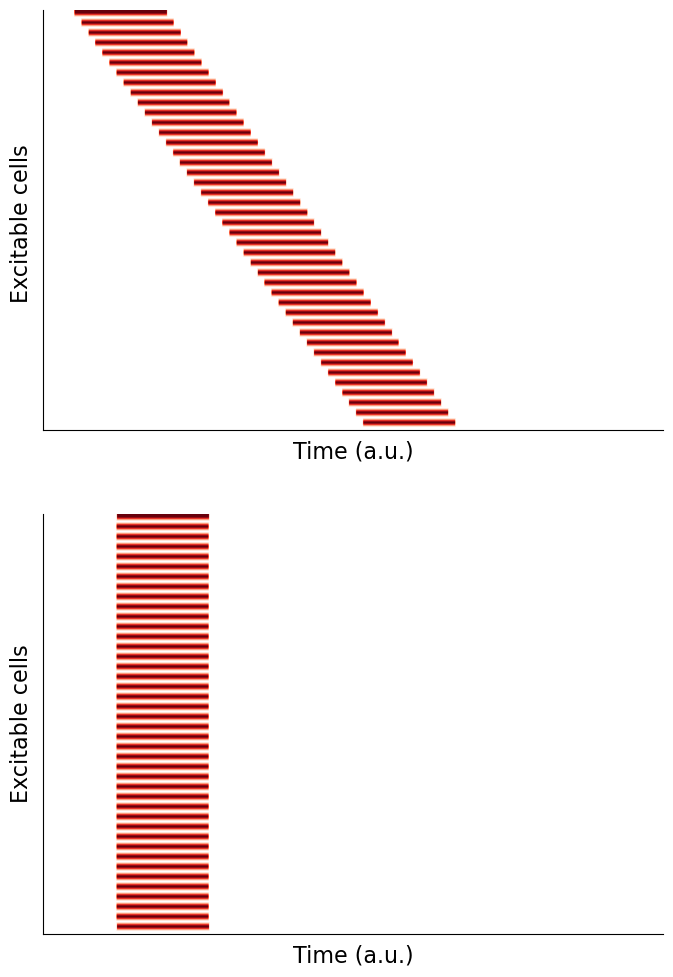

In [17]:
# Get the specific slices

data1 = binary1[20, 4:(N_y-4), :]

data2 = binary1[4:(N_y-4), 10, :]

# Add blank rows between binary rows for data1
N1, T1 = data1.shape
gap1 = 1  # Gap size (number of blank rows)
data1_with_blanks = np.zeros((N1 * (gap1 + 1), T1))
for i in range(N1):
    data1_with_blanks[i * (gap1 + 1), :] = data1[i, :]

# Add blank rows between binary rows for data2
N2, T2 = data2.shape
gap2 = 1  # Gap size (number of blank rows)
data2_with_blanks = np.zeros((N2 * (gap2 + 1), T2))
for i in range(N2):
    data2_with_blanks[i * (gap2 + 1), :] = data2[i, :]

# Create a custom colormap (transparent for 0, red for 1)
cmap = plt.cm.Reds
cmap = cmap(np.arange(cmap.N))
cmap[0, -1] = 0  # Set the alpha value of the first color (for 0) to 0 (fully transparent)
cmap = plt.matplotlib.colors.ListedColormap(cmap)


# Plot the data
plt.figure(figsize=(8, 12), facecolor='none')

# Plot data1
plt.subplot(2, 1, 1)
plt.imshow(data1_with_blanks, cmap=cmap, vmin=0, vmax=1, aspect='auto')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.ylabel("Excitable cells ", fontsize=16)
plt.xlabel("Time (a.u.)", fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)

# Plot data2
plt.subplot(2, 1, 2)
plt.imshow(data2_with_blanks, cmap=cmap, vmin=0, vmax=1, aspect='auto')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.ylabel("Excitable cells", fontsize=16)
plt.xlabel("Time (a.u.)", fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)

plt.show()

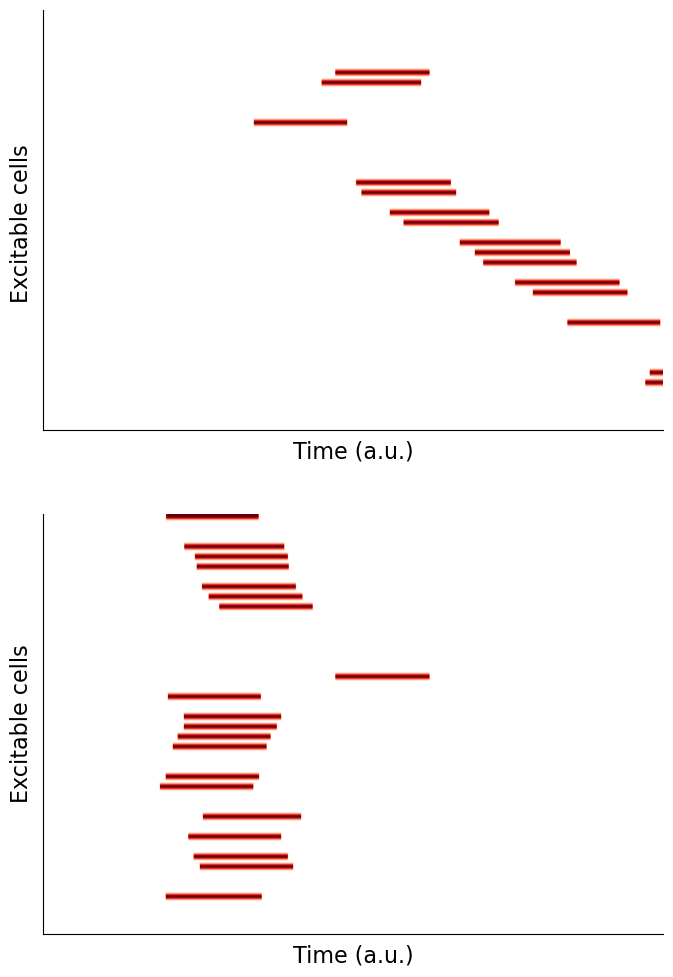

In [20]:
# Get the specific slices

data1 = binary2[20, 4:(N_y-4), :]

data2 = binary2[4:(N_y-4), 10, :]

# Add blank rows between binary rows for data1
N1, T1 = data1.shape
gap1 = 1  # Gap size (number of blank rows)
data1_with_blanks = np.zeros((N1 * (gap1 + 1), T1))
for i in range(N1):
    data1_with_blanks[i * (gap1 + 1), :] = data1[i, :]

# Add blank rows between binary rows for data2
N2, T2 = data2.shape
gap2 = 1  # Gap size (number of blank rows)
data2_with_blanks = np.zeros((N2 * (gap2 + 1), T2))
for i in range(N2):
    data2_with_blanks[i * (gap2 + 1), :] = data2[i, :]

# Create a custom colormap (transparent for 0, red for 1)
cmap = plt.cm.Reds
cmap = cmap(np.arange(cmap.N))
cmap[0, -1] = 0  # Set the alpha value of the first color (for 0) to 0 (fully transparent)
cmap = plt.matplotlib.colors.ListedColormap(cmap)


# Plot the data
plt.figure(figsize=(8, 12), facecolor='none')

# Plot data1
plt.subplot(2, 1, 1)
plt.imshow(data1_with_blanks, cmap=cmap, vmin=0, vmax=1, aspect='auto')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.ylabel("Excitable cells ", fontsize=16)
plt.xlabel("Time (a.u.)", fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)

# Plot data2
plt.subplot(2, 1, 2)
plt.imshow(data2_with_blanks, cmap=cmap, vmin=0, vmax=1, aspect='auto')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.ylabel("Excitable cells", fontsize=16)
plt.xlabel("Time (a.u.)", fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)

plt.show()

([], [])

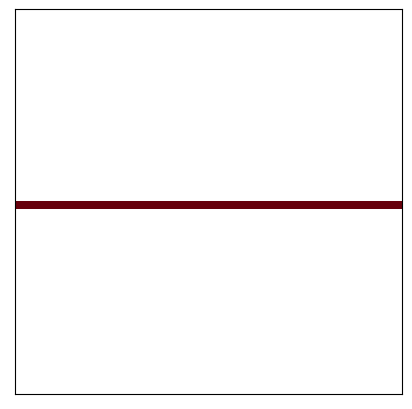

In [21]:

box1 = np.zeros((50, 50))
box1[25, :] = 1  # Set the 26th row to ones

# Create the second box with a column of ones
box2 = np.zeros((50, 50))
box2[:, 25] = 1  # Set the 26th column to ones
# Plot the data
plt.figure(figsize=(5, 5), facecolor='none')

# Plot box1

plt.imshow(box1, cmap=cmap, vmin=0, vmax=1, aspect='auto')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks






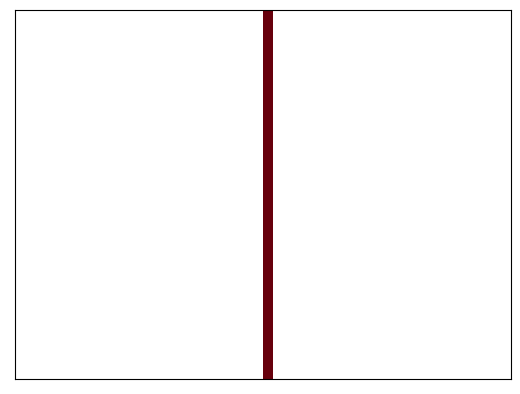

In [ ]:
# Plot box2
plt.figure(figsize=(5, 5), facecolor='none')
plt.imshow(box2, cmap=cmap, vmin=0, vmax=1, aspect='auto')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks

plt.show()